In [1]:
from pyspark.sql import SparkSession
from urllib.request import urlretrieve
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.executor.memory","4G")
    .config("spark.driver.memory","8G")
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

22/08/22 01:46:42 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.17.1.121 instead (on interface eth0)
22/08/22 01:46:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 01:46:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/22 01:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/22 01:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/22 01:46:45 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
spark.conf.set("spark.sql.parquet.compression.codec", "gzip")

In [3]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium

In [4]:
YEARS = ['2019', '2021']
MONTHS = range(1, 13)
path = f"../data/curated/tlc_data/"
cols = ['is_weekend', 'is_airport', 'is_rainy']
count = 0


In [5]:
# create an empty dataset to store the values that will be used to plot
def create_plot_df():
    plot_df = pd.DataFrame(columns = ['year', 'month', 'avg_tip_amount', 'avg_tip_rate'], index = range(24))
    return plot_df

In [6]:
# fill the avg tip amount and tip rate with respect to each month in each year
def fill_df(count, year, month, sdf, plot_df):
    plot_df.iloc[count, 0] = year
    plot_df.iloc[count, 1] = month
    plot_df.iloc[count, 2] = sdf.select(F.mean('tip_amount')).head()[0]
    plot_df.iloc[count, 3] = sdf.select(F.mean('tip_rate')).head()[0]

In [7]:
# plot the line graph to compare the tip amount in two years
def plot_line(plot_df):
    sbs.set_theme(style = 'darkgrid')
    fig = sbs.lineplot(x = 'month', y = 'avg_tip_amount', data = plot_df, hue = 'year', markers = True)
    plt.ylabel('Avg Tip Amount', size = 12)
    sbs.scatterplot(x = 'month', y = 'avg_tip_amount', data = plot_df, hue = 'year', markers = True, legend = False)
    fig.set_ylim(1, 3)
    plt.title('2019 vs 2021 Avg Tip Amount')
    # save the figure
    plt.savefig("../plots/2019 vs 2021 Avg Tip Amount")
    plt.show()

In [8]:
# plot the line graph to compare the tip rate in two years
def plot_rate(plot_df):
    fig = sbs.lineplot(x = 'month', y = 'avg_tip_rate', data = plot_df, hue = 'year', markers = True)
    sbs.scatterplot(x = 'month', y = 'avg_tip_rate', data = plot_df, hue = 'year', markers = True, legend = False)
    plt.ylabel('Avg Tip Amount', size = 12)
    fig.set_ylim(0.15, 0.3)
    plt.title('2019 vs 2021 Avg Tip Rate')
    # save the figure
    plt.savefig("../plots/2019 vs 2021 Avg Tip Rate")
    plt.show()

finished 2019 01
finished 2019 02
finished 2019 03
finished 2019 04
finished 2019 05
finished 2019 06
finished 2019 07
finished 2019 08
finished 2019 09
finished 2019 10
finished 2019 11
finished 2019 12
finished 2021 01
finished 2021 02
finished 2021 03
finished 2021 04
finished 2021 05
finished 2021 06
finished 2021 07
finished 2021 08
finished 2021 09
finished 2021 10
finished 2021 11
finished 2021 12


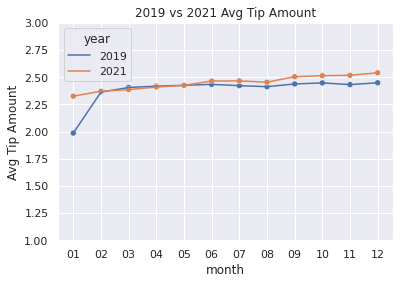

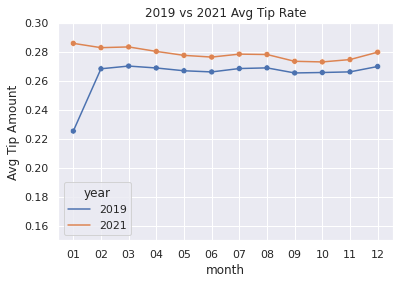

In [9]:
# initialise the plot dataframe
plot_df = create_plot_df()
for year in YEARS:
    for month in MONTHS:
        month = str(month).zfill(2)
        sdf = spark.read.parquet(f'{path}{year}/final_data/{year}--{month}-final_merged.parquet')
        # find the average tip amount and tip rate with respect to each month
        fill_df(count, year, month, sdf, plot_df)
        count += 1
        
        
        print(f'finished {year} {month}')

plot_line(plot_df)
plot_rate(plot_df)

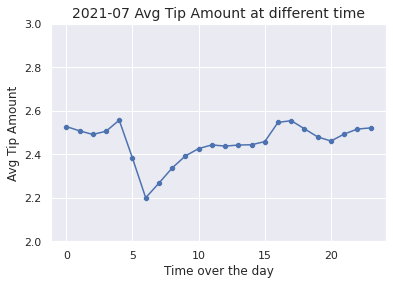

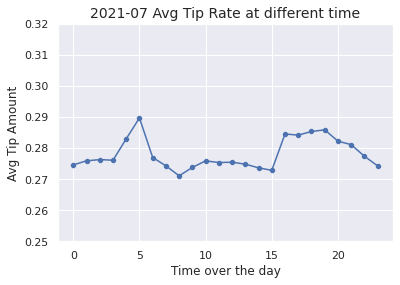

In [10]:
# take 2021-07 as an example
sdf = spark.read.parquet(f'{path}2021/final_data/2021--07-final_merged.parquet')

# look at the average tip amount and tip rate with respect to different time in a day
aggregate_by_time = sdf\
                    .groupBy('Pickup_time')\
                    .agg(
                        # take the mean value of each
                        F.mean("tip_amount").alias("avg_tip_amount"),
                        F.mean("tip_rate").alias("avg_tip_rate")
                    )\
                    .orderBy('Pickup_time')


pd_aggregate_by_time = aggregate_by_time.toPandas()

# plot the result of the previous aggregation
# plot of tip amount
sbs.set_theme(style = 'darkgrid')
fig = sbs.lineplot(x = 'Pickup_time', y = 'avg_tip_amount', data = pd_aggregate_by_time, markers = True)
plt.xlabel('Time over the day', size = 12)
plt.ylabel('Avg Tip Amount', size = 12)
sbs.scatterplot(x = 'Pickup_time', y = 'avg_tip_amount', data = pd_aggregate_by_time, markers = True, legend = False)
fig.set_ylim(2, 3)
plt.title('2021-07 Avg Tip Amount at different time', size = 14)
# save the figure
plt.savefig('../plots/2021-07 avg_tip_amount at different time')
plt.show()

# plot of tip rate
fig = sbs.lineplot(x = 'Pickup_time', y = 'avg_tip_rate', data = pd_aggregate_by_time, markers = True)
sbs.scatterplot(x = 'Pickup_time', y = 'avg_tip_rate', data = pd_aggregate_by_time, markers = True, legend = False)
plt.xlabel('Time over the day', size = 12)
plt.ylabel('Avg Tip Amount', size = 12)
fig.set_ylim(0.25, 0.32)
plt.title('2021-07 Avg Tip Rate at different time', size = 14)
# save the figure
plt.savefig('../plots/2021-07 avg_tip_rate at different time')
plt.show()